In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

# Load annotations

In [7]:
cell_line_info = pd.read_csv("../data/sample_info.csv")
cell_line_annotations = pd.read_excel("../data/41586_2019_1186_MOESM4_ESM.xlsx",
                                      sheet_name="Cell Line Annotations")

hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
tertp = pd.read_excel("../data/41586_2019_1186_MOESM8_ESM.xlsx",skiprows=4)

fusions = pd.read_csv("../data/CCLE_Fusions_20181130.txt",sep="\t")
copynumber = pd.read_hdf("../data/CCLE_gene_cn.hdf",key="copynumber")
copynumber = copynumber.dropna(how="any",thresh=1000,axis=1)

tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")

ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")
exonusage = pd.read_hdf("../data/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",key="exonusage")

mirna = pd.read_hdf("../data/CCLE_miRNA_20181103.hdf",key="mirna")
chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
rppa = pd.read_hdf("../data/CCLE_RPPA_20181003.hdf",key="rppa")

msi = pd.read_excel("../data/41586_2019_1186_MOESM10_ESM.xlsx",sheet_name="MSI calls")
absolute = pd.read_excel("../data/CCLE_ABSOLUTE_combined_20181227.xlsx",
                         sheet_name = "ABSOLUTE_combined.table")

# Cell line primary sites

In [200]:
subtypes = cell_line_annotations[["depMapID","type_refined"]].set_index("depMapID")
subtypes = subtypes["type_refined"]
subtypes = subtypes.dropna()
subtypes = subtypes.apply(lambda x: x.capitalize().replace("_"," "))

rename_map = {"T-cell lymphoma other":"Other T-cell lymphoma",
              "Aml":"AML",
              "Ewings sarcoma": "Ewing's sarcoma",
              "Fibroblast like":"Fibroblast-like",
              "Lung nsc":"Lunc, NSC",
              "Lymphoma hodgkin":"Hodgkin's lymphoma",
              "Lymphoma dlbcl":"DLBCL",
              "T-cell all":"T-cell ALL",
              "B-cell all":"B-cell ALL",
              "Cml":"CML",
              "B-cell lymphoma other":"Other B-cell lymphoma",
              "Leukemia other":"Other leukemia",
              "Lymphoma burkitt":"Burkitt's lymphoma"
             }

subtypes = subtypes.apply(lambda x:rename_map.get(x,x))

# Top recurrent mutations

In [16]:
def get_top_muts():
    
    align_hs_muts, align_damaging_muts = hs_muts.align(damaging_muts,join="outer",axis=1)
    align_hs_muts = align_hs_muts.fillna(0)
    align_damaging_muts = align_damaging_muts.fillna(0)
    
    hs_damaging_muts = (align_hs_muts+align_damaging_muts).clip(0,1)
        
    mut_totals = hs_damaging_muts.sum()
    mut_totals = mut_totals.sort_values()
    
    return hs_damaging_muts[mut_totals.index[-8:]]
    
muts = get_top_muts()

# TERT promoter mutations

In [69]:
tertp_mut = tertp[["depMapID","TERT_promoter_mutation"]].set_index("depMapID")!="wildtype"

# Fusions

In [17]:
def get_fusions():

    fusions["value"] = 1

    fusions_mat = pd.pivot_table(fusions, values="value",
                                index=["BroadID"], columns="X.FusionName", fill_value=0)
    
    fusions_mat.columns = fusions_mat.columns.map(lambda x: x.replace("--","-"))

    return fusions_mat[["BCR-ABL1","EWSR1-FLI1","KMT2A-MLLT3"]]

select_fusions = get_fusions()

# Top continuous annotations

In [18]:
def top_variable(annotations, top_n,clip_left=-3,clip_right=3):
    
    stdevs = annotations.std()
    stdevs = stdevs.sort_values()
    
    top_names = stdevs.index[-top_n:]
    
    top_annotations = annotations[top_names]
    top_annotations = (top_annotations - top_annotations.mean())/top_annotations.std()
    
    top_annotations = top_annotations.clip(clip_left,clip_right)
    
    return top_annotations

In [168]:
select_copynumber = top_variable(copynumber, 1000)
select_meth = top_variable(tss1kb_meth, 1000)
select_genex = top_variable(ccle_genex, 1000)
select_exonusage = top_variable(exonusage, 1000)
select_mirna = top_variable(mirna, 1000)
select_chromatin = top_variable(chromatin_profiling, 1000)
select_rppa = top_variable(rppa, 1000)

select_copynumber.columns = [x + "_copynumber" for x in select_copynumber.columns]
select_meth.columns = [x + "_meth" for x in select_meth.columns]
select_genex.columns = [x + "_genex" for x in select_genex.columns]
select_exonusage.columns = [x + "_exonusage" for x in select_exonusage.columns]
select_mirna.columns = [x + "_mirna" for x in select_mirna.columns]
select_chromatin.columns = [x + "_chromatin" for x in select_chromatin.columns]
select_rppa.columns = [x + "_rppa" for x in select_rppa.columns]

# MSI, ploidy, and ancestry

In [169]:
is_msi = msi[msi["CCLE.MSI.call"].isin(['inferred-MSI','inferred-MSS'])]
is_msi = is_msi[["depMapID","CCLE.MSI.call"]].set_index("depMapID")
is_msi = is_msi == "inferred-MSI"

ploidy = absolute[["depMapID","ploidy"]].set_index("depMapID")
ploidy = ploidy.loc[~ploidy.index.duplicated(keep='first')]

ancestry = cell_line_annotations[["inferred_ancestry","depMapID"]].set_index("depMapID").dropna()

# Cluster subtypes

In [206]:
cluster_df = pd.concat([select_copynumber,
                        select_meth,
                        select_genex,
                        select_exonusage,
                        select_mirna,
                        select_chromatin,
                        select_rppa
                       ],join="outer",axis=1,sort=True)

cluster_df, align_subtypes = cluster_df.align(subtypes,axis=0,join="inner")

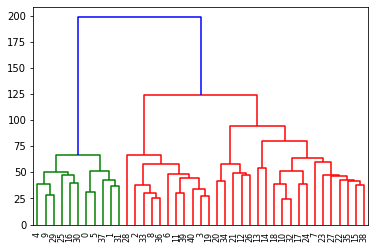

In [207]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

subtype_means = cluster_df.groupby(align_subtypes).mean()

subtype_linkage = hc.linkage(subtype_means.fillna(subtype_means.mean()), method='ward')
leaf_order = hc.dendrogram(subtype_linkage)["leaves"]

subtype_order = np.array(subtype_means.index)[leaf_order]
subtype_order = dict(zip(subtype_order,range(len(subtype_order))))

# Merge all 

In [208]:
continuous_annotations = np.concatenate([
    select_copynumber.columns,
    select_meth.columns,
    select_genex.columns,
    select_exonusage.columns,
    select_mirna.columns,
    select_chromatin.columns,
    select_rppa.columns,
])

In [209]:
merged_all = pd.concat([
                        subtypes,
                        
                        muts,
                        tertp_mut,
                        select_fusions,
    
                        select_copynumber,
                        select_meth,
                        select_genex,
                        select_exonusage,
                        select_mirna,
                        select_chromatin,
                        select_rppa,
                        
                        is_msi,
                        ploidy,
                        ancestry,
                       ],join="outer",axis=1,sort=True)

In [210]:
merged_all = merged_all.dropna(how="any",subset=["type_refined"],axis=0)

merged_all = merged_all.dropna(how="all",subset=select_copynumber.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_meth.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_genex.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_mirna.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_chromatin.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_rppa.columns,axis=0)

merged_all = merged_all.dropna(how="any",subset=is_msi.columns,axis=0)
merged_all = merged_all.dropna(how="any",subset=ploidy.columns,axis=0)
merged_all = merged_all.dropna(how="any",subset=ancestry.columns,axis=0)

In [211]:
merged_all["type_order_index"] = merged_all["type_refined"].apply(lambda x: subtype_order[x])
merged_all = merged_all.sort_values(by="type_order_index")

In [212]:
def within_subtype_order(subtype_annotations):
    continuous = subtype_annotations[continuous_annotations]
    
    cell_line_linkage = hc.linkage(continuous.fillna(0), method='ward')
    leaf_order = hc.dendrogram(cell_line_linkage,no_plot=True)["leaves"]
    
    return np.array(continuous.index[leaf_order])

In [213]:
type_counts = Counter(merged_all["type_refined"])

merged_all["type_count"] = merged_all["type_refined"].apply(lambda x: type_counts[x])

merged_all = merged_all[merged_all["type_count"]>=5]

In [214]:
total_order = pd.DataFrame(merged_all.groupby("type_refined").apply(within_subtype_order))
total_order["type_order_index"] = total_order.index.map(lambda x: subtype_order[x])
total_order = total_order.sort_values(by="type_order_index")
total_order = np.concatenate(total_order[0])


In [215]:
merged_all = merged_all.loc[total_order]

In [216]:
merged_all.to_hdf("../data/merged_overview.h5",key="merged_all")

# Make final plot

TypeError: ("unsupported operand type(s) for -: 'tuple' and 'float'", 'occurred at index 0')

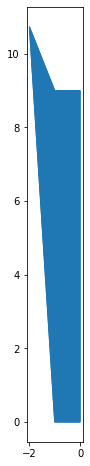

In [277]:
unique_types = pd.DataFrame(merged_all["type_refined"].drop_duplicates(keep="first"))
unique_types.index = np.arange(len(unique_types))

type_counts = dict(Counter(merged_all["type_refined"]))

unique_types["count"] = unique_types["type_refined"].apply(lambda x: type_counts[x])

total_lines = unique_types["count"].sum()

unique_types["cumulative_count"] = unique_types["count"].cumsum()
unique_types["cumulative_offset"] = [0]+list(unique_types["cumulative_count"][:-1])

unique_types["spaced_position"] = unique_types.index/len(unique_types)*total_lines+total_lines/len(unique_types)*0.5

subtype_palette = sns.color_palette("tab20", len(unique_types["type_refined"].unique()))
subtype_color_map = dict(zip(unique_types["type_refined"].unique(), subtype_palette))
subtype_colors = unique_types["type_refined"].map(subtype_color_map)

unique_types["subtype_color"] = subtype_colors

def plot_subtype(row,ax):
    y = [row["cumulative_offset"],
         row["cumulative_offset"],
         row["spaced_position"],
         row["cumulative_count"],
         row["cumulative_count"]
        ]
    
    x = [0,-1,-2,-1,0]
    
    ax.fill(x,y,c=row["subtype_color"])
    
    plt.plot(-2,row["spaced_position"],marker="o",c=row["subtype_color"]-0.1)
    
    ax.text(-2.25,row["spaced_position"],row["type_refined"],ha="right",va="center")

plt.figure(figsize=(1,8))

ax = plt.subplot(111)
unique_types.apply(plot_subtype,ax=ax,axis=1)

ax.set_ylim(0,total_lines)

ax.axis('off')

In [256]:
unique_types

,type_refined,count,cumulative_count,cumulative_offset,spaced_position,subtype_color
0,Burkitt's lymphoma,9,9,0,0.000000,"(0.12156862745098039, 0.4666666666666667, 0.70..."
1,DLBCL,15,24,24,21.470588,"(0.6823529411764706, 0.7803921568627451, 0.909..."
2,Other B-cell lymphoma,12,36,36,42.941176,"(1.0, 0.4980392156862745, 0.054901960784313725)"
3,Multiple myeloma,19,55,55,64.411765,"(1.0, 0.7333333333333333, 0.47058823529411764)"
4,Hodgkin's lymphoma,6,61,61,85.882353,"(0.17254901960784313, 0.6274509803921569, 0.17..."
5,Other T-cell lymphoma,5,66,66,107.352941,"(0.596078431372549, 0.8745098039215686, 0.5411..."
6,AML,28,94,94,128.823529,"(0.8392156862745098, 0.15294117647058825, 0.15..."
7,CML,12,106,106,150.294118,"(1.0, 0.596078431372549, 0.5882352941176471)"
8,T-cell ALL,9,115,115,171.764706,"(0.5803921568627451, 0.403921568627451, 0.7411..."
9,B-cell ALL,12,127,127,193.235294,"(0.7725490196078432, 0.6901960784313725, 0.835..."
